# Chrome Dino environment development
![](http://www.skipser.com/test/trex-game/promotion/trex-chrome-game.png)

In [1]:
# Usual
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import time
from tqdm import tqdm

# Autoreload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

Game is available at https://chromedino.com/

##### Summary
- Capturing image from the game - **OK**
- Allowing control programmatically - **OK**
- Trying a simple implementation of rules-based agent with classic CV algorithms - **OK** 
- Capturing scores for fitness and reward - **OK**
- Creating the environment for RL - **OK**
- Developing a RL agent that learns via evolution strategies
  - Feature engineering the input with detected boundaries
  - Taking raw image as input
  - Taking processed image as input
  - Initialize the agent with hard coded policy
- Combine the RL agent and the rules-based Agent

##### Additional content
- Forcing size to ensure compatibility and reproducibility
- Using the framework to have multiple games at the same time ?


##### References on OpenCV
- [OpenCV docs](https://docs.opencv.org/3.1.0/dd/d3b/tutorial_py_svm_opencv.html)
- [OpenCV tutorials](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html)
- [Sentdex tutorials](https://pythonprogramming.net/loading-images-python-opencv-tutorial/)

##### References on RL
- [Genetic algorithms tutorial](https://nathanrooy.github.io/posts/2017-11-30/evolving-simple-organisms-using-a-genetic-algorithm-and-deep-learning/?utm_source=mybridge&utm_medium=blog&utm_campaign=read_more)

***

# Capturing image from the game

In [2]:
import cv2
from PIL import Image,ImageGrab

##### Test with imagegrab
Image grab takes a bounding box with coordinates ``left,top,right,bottom``

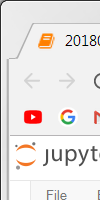

In [15]:
ImageGrab.grab(bbox=(0,0,100,200))

###### Get screen size

In [16]:
def get_size():
    img = ImageGrab.grab()
    return img.size
get_size()

(1920, 1080)

In [18]:
1920/2

960.0

##### Get ROI (Region Of Interest)

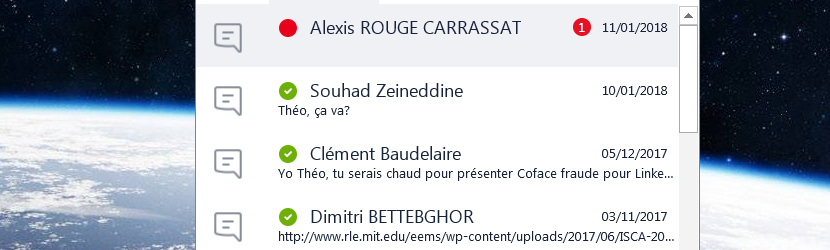

In [3]:
def grab_roi():
    return ImageGrab.grab(bbox=(1020,350,1850,600))

grab_roi()

***

# Allowing control programmatically

http://pyautogui.readthedocs.io/en/latest/keyboard.html

In [4]:
import pyautogui
import time
import random

###### Pressing up

In [40]:
pyautogui.press("up")

##### Planning multiple presses

In [42]:
t = time.time()
while time.time() - t < 3:
    print("UP")
    time.sleep(random.random()*2)
    pyautogui.press("up")

UP
UP
UP
UP
UP
UP


##### Moving mouse to other screen

In [44]:
pyautogui.click(x=1000,y = 500)
time.sleep(1)
pyautogui.press("up")

##### Random game for 10s

In [8]:
t = time.time()
pyautogui.click(x=1000,y = 500)
while time.time() - t < 10:
    print("UP")
    time.sleep(random.random()*2)
    pyautogui.press("up")

UP
UP
UP
UP
UP
UP
UP
UP
UP


***

# Try a simple implementation with classic CV algorithms

## Preparing the preprocessing

##### Capturing a sample image of the game

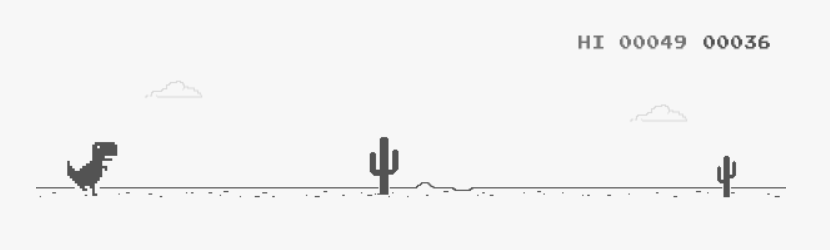

In [48]:
img = grab_roi()
img

##### Saving for further use

In [49]:
img.save("images/capture1.png")

In [20]:
img = Image.open("images/capture1.png")

In [21]:
img_array = np.array(img)

##### Detecting edges

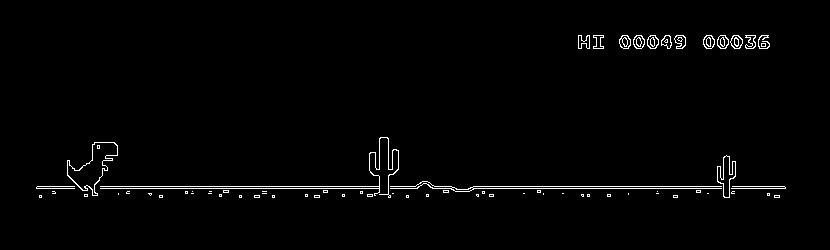

In [22]:
img_edges = cv2.Canny(img_array,100,200)
Image.fromarray(img_edges)

##### Applying a mask

In [5]:
def extract_game(img):
    mask = np.zeros_like(img)
    mask[80:220,130:800] = 255
    masked = cv2.bitwise_and(img,mask)
    return masked

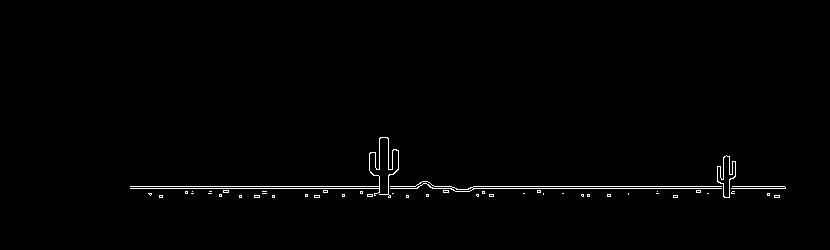

In [24]:
img_mask = extract_game(img_edges)
Image.fromarray(img_mask)

##### Morphological transformations to extract positions

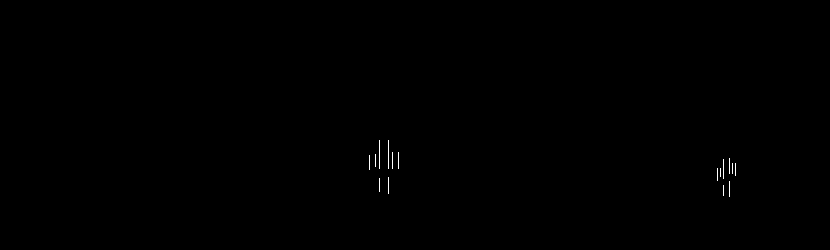

In [135]:
img_eroded = cv2.erode(img_mask,np.ones((4,1),np.uint8))
Image.fromarray(img_eroded)

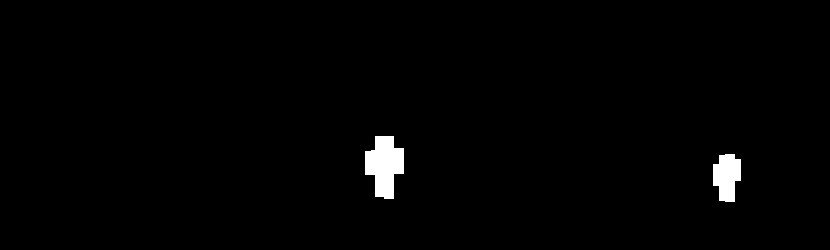

In [136]:
img_dilated = cv2.dilate(img_eroded,np.ones((10,10),np.uint8))
Image.fromarray(img_dilated)

##### Finding contours

In [160]:
im,contours,_ = cv2.findContours(img_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

In [161]:
print(im.shape)
im = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
print(im.shape)

(250, 830)
(250, 830, 3)


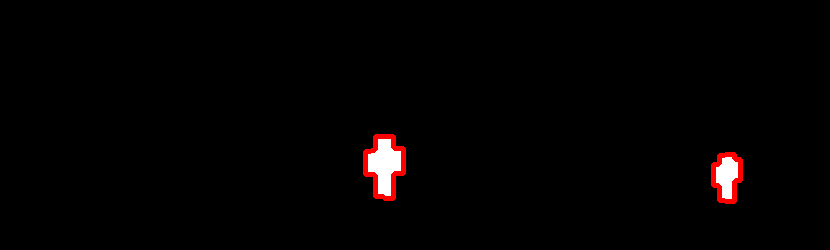

In [162]:
cv2.drawContours(im, contours, -1, (255,0,0), 3)
Image.fromarray(im)

##### Extracting left positions from contours

In [164]:
len(contours)

2

In [173]:
contours[0].min(axis = 0)[0][0]

713

In [174]:
contours[1].min(axis = 0)[0][0]

365

In [175]:
im.shape

(250, 830, 3)

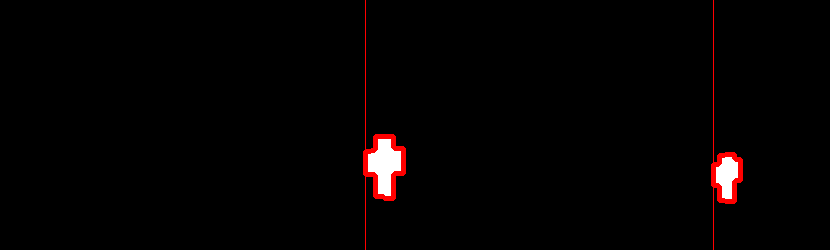

In [179]:
im2 = im.copy()
cv2.line(im2,(365,0),(365,250),(255,0,0),1)
cv2.line(im2,(713,0),(713,250),(255,0,0),1)
Image.fromarray(im2)

## Combine all the steps in a processing function

In [6]:
def process_input(img):
    img_array = np.array(img)
    img_edges = cv2.Canny(img_array,100,200)
    img_mask = extract_game(img_edges)
    img_eroded = cv2.erode(img_mask,np.ones((4,1),np.uint8))
    img_dilated = cv2.dilate(img_eroded,np.ones((10,10),np.uint8))
    img_contours,contours,_ = cv2.findContours(img_dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    img_contours = cv2.cvtColor(img_contours,cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_contours, contours, -1, (255,0,0), 3)
    img_lines = img_contours.copy()
    xs = list(sorted([y.min(axis = 0)[0][0] for y in contours]))
    for x in xs:
        cv2.line(img_lines,(x,0),(x,img_lines.shape[0]),(255,0,0),1)
    return img_lines,xs

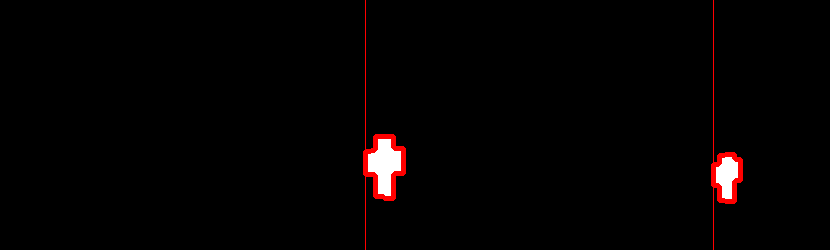

In [183]:
img_lines,xs = process_input(img)
Image.fromarray(img_lines)

In [184]:
xs

[365, 713]

##### Test with another sample image

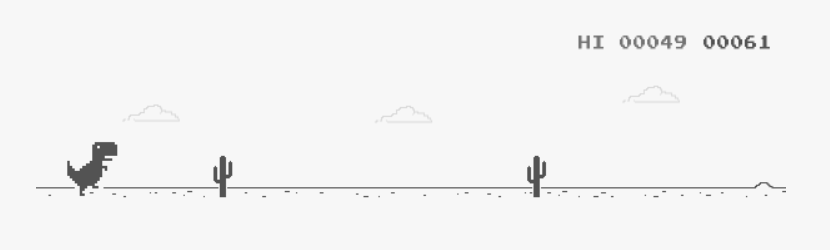

In [185]:
img2 = grab_roi()
img2

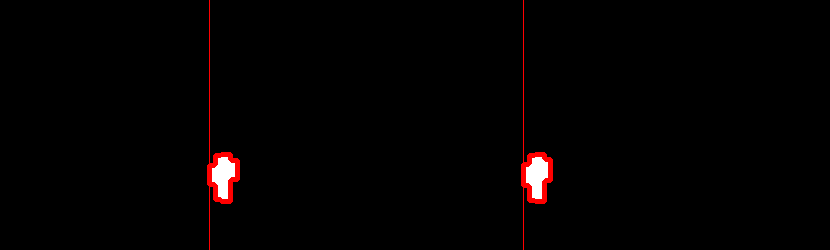

In [186]:
Image.fromarray(process_input(img2)[0])

## Use the boundaries to create the hard coded Agent

##### Game routine

In [22]:
t = time.time()
pyautogui.click(x=1000,y = 500)
while True:
    time.sleep(0.05)
    roi = grab_roi()
    print(np.array(roi).shape)
    roi_processed,xs = process_input(roi)
    if len(xs) > 0 and xs[0] < 300:
        pyautogui.press("up")

(250, 830, 3)


##### First conclusions

- This hard coded agent works already pretty well. <br>
- Without spending a lot of time fine tuning the parameters, it can already avoid most of the cactuses till at least 400 points. <br>
- You can see a game example below
![](images/dino_hardcoded_agent.gif)

However, there are multiple problems with this approach : 
- The dinosaur **has trouble to plan ahead** and is only considering the first cactus to choose when to jump. This can cause problem when ideally we would want to jump a little ahead to have space for the second cactus. However, we could still create a more complicated rule to consider this situation 
- The dinosaur only knows **how to jump, and not how to duck**, this can be a problem when birds will appear after in the game. 
- Moreover, as the agent is not strong enought to reach the birds level. We don't have yet any images to tune our processing to find birds in the image. 
- Finally, the agent does not react differently to speed going up while playing

##### In a nutshell
- We could still improve this hard coded agent to be even better, but this is not the purpose of this project
- However, this is a good baseline to know how far we can go with rules in this game : around 500 points
- We could even initialize our reinforcement learning agents to the hard coded policy to skip the first training part of our agent

***

# Capturing scores

To create our **Reinforcement Learning model**, we will need a reward for each game or a measure of fitness in the case of genetic algorithms.<br>
This will be pretty easy here as we have a score for the game. Yet we will have two ways of extracting the score in real time : 
- **OCRizing the image** to extract and read the score
- Simply **track time before game over**

Yet, both have pros and cons : 
- Tracking time will reflect a score different from the one shown, which is not really a problem but in other Machine Learning problems it is dangerous to optimize a function on a different objective than the real one
- OCRizing is complex and slow, subject to errors that could be propagated through the model. And as we want to have it in real time, we cannot use really accurate algorithms such as SVMs or Neural Networks. 

We will still try both approach for the sake of the game. 

## OCRizing score with ML computer vision models

### Extract each digits

##### Extract score ROI

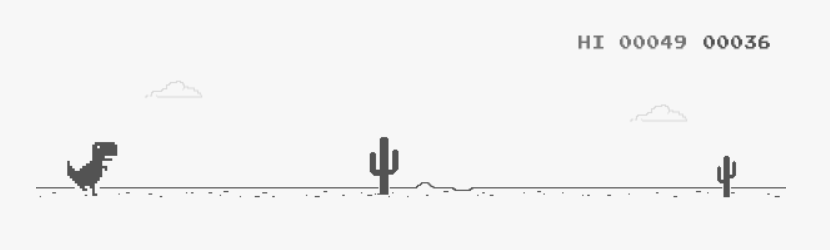

In [45]:
Image.fromarray(img_array)

In [46]:
def extract_score(img):
    return img[25:60,695:780]

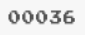

In [79]:
img_score = extract_score(img_array)
img_score = cv2.cvtColor(img_score,cv2.COLOR_BGR2GRAY)
Image.fromarray(img_score)

##### Thresholding and erosion

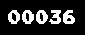

In [165]:
_,score_th = cv2.threshold(img_score,210,255,cv2.THRESH_BINARY_INV)
Image.fromarray(score_th)

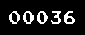

In [202]:
score_eroded = cv2.erode(score_th,np.ones((2,2),np.uint8))
Image.fromarray(score_eroded)

##### Find the bounding rectangle for all digits

In [203]:
im,contours,_ = cv2.findContours(score_eroded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
im = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)

In [204]:
len(contours)

5

In [205]:
boxes = [cv2.boundingRect(c) for c in contours]
boxes = [box for box in boxes if box[2] > 9 and box[3] > 10]
boxes = list(sorted(boxes,key = lambda x : x[0]))
boxes

[(9, 11, 11, 13),
 (23, 11, 11, 13),
 (37, 11, 11, 13),
 (51, 11, 10, 13),
 (64, 11, 11, 13)]

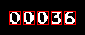

In [206]:
for box in boxes:
    (x, y, w, h) = box
    cv2.rectangle(im, (x, y), (x + w, y + h),(255,0,0), 1)
Image.fromarray(im)

##### Extract each digits

In [208]:
digits = []
for (x, y, w, h) in boxes:
    digits.append(score_eroded[y:y+h,x:x+w])
Image.fromarray(digits[4])

### Recognize the digits with the MNIST dataset

At first, I thought this step would be the simplest, as OCRizing digits is a well known and solved problem. However : 
- I tried ``Tesseract`` using ``Pytesseract`` which only achieved a unsatisfactory accuracy
- I could not find an easy pre-trained library or API

Thus I had to go back to two remaining solutions :
- Either extract multiple digits from source, cluster them to help their labelling, then train a model
- Use the famous MNIST dataset to train the model

In [177]:
from sklearn import datasets
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split

##### Loading the MNIST dataset

In [179]:
dataset = datasets.fetch_mldata("MNIST Original")
X,y = dataset.data,dataset.target

##### Selecting a small subset for quick training

In [180]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.98)

In [181]:
X_train.shape

(1400, 784)

##### Testing different models

In [182]:
scores = cross_val_score(LogisticRegression(),X_train,y_train,cv = 3)
scores.mean()

0.81497812824647775

In [183]:
scores = cross_val_score(MLPClassifier(hidden_layer_sizes=(100,100)),X_train,y_train,cv = 3)
scores.mean()

0.7678331969268174

In [192]:
scores = cross_val_score(KNeighborsClassifier(),X_train,y_train,cv = 3)
scores.mean()

0.86206098384209973

##### Training the models

In [184]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [195]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [188]:
mlp = MLPClassifier(hidden_layer_sizes=(100,100))
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

##### Helper function to prepare the input the image

In [172]:
def prepare_image_for_mnist_input(img):
    img = Image.fromarray(img)
    img = img.resize((20,20))
    mask = np.zeros((28,28),np.uint8)
    mask[4:24,4:24] = img
    return mask.reshape(1,-1)

In [209]:
print("Logistic Regression")
for img_digit,true in zip(digits,[0,0,0,3,6]):
    print("- True {} - predicted {}".format(true,lr.predict(prepare_image_for_mnist_input(img_digit))))

Logistic Regression
- True 0 - predicted [ 0.]
- True 0 - predicted [ 0.]
- True 0 - predicted [ 0.]
- True 3 - predicted [ 3.]
- True 6 - predicted [ 5.]


In [210]:
print("KNN")
for img_digit,true in zip(digits,[0,0,0,3,6]):
    print("- True {} - predicted {}".format(true,knn.predict(prepare_image_for_mnist_input(img_digit))))

KNN
- True 0 - predicted [ 0.]
- True 0 - predicted [ 0.]
- True 0 - predicted [ 0.]
- True 3 - predicted [ 3.]
- True 6 - predicted [ 5.]


In [211]:
print("MLP")
for img_digit,true in zip(digits,[0,0,0,3,6]):
    print("- True {} - predicted {}".format(true,mlp.predict(prepare_image_for_mnist_input(img_digit))))

MLP
- True 0 - predicted [ 0.]
- True 0 - predicted [ 0.]
- True 0 - predicted [ 0.]
- True 3 - predicted [ 3.]
- True 6 - predicted [ 2.]


##### Define the end to end function

In [242]:
def get_score():
    roi = grab_roi()
    img_array = np.array(roi)
    img_score = extract_score(img_array)
    img_score = cv2.cvtColor(img_score,cv2.COLOR_BGR2GRAY)
    _,score_th = cv2.threshold(img_score,210,255,cv2.THRESH_BINARY_INV)
    score_eroded = cv2.erode(score_th,np.ones((2,2),np.uint8))

    im,contours,_ = cv2.findContours(score_eroded.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    im = cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
    
    
    boxes = [cv2.boundingRect(c) for c in contours]
    boxes = [box for box in boxes if box[2] > 9 and box[3] > 10]
    boxes = list(sorted(boxes,key = lambda x : x[0]))
    
    digits = []
    for (x, y, w, h) in boxes:
        digits.append(score_eroded[y:y+h,x:x+w])

    digits = [prepare_image_for_mnist_input(digit) for digit in digits]
    digits = np.vstack(digits)
    len(digits)
    assert len(digits) == 5
    
    pred = np.int16(knn.predict(digits))
    pred = "".join([str(int(x)) for x in pred])
    pred = int(pred)
    
    plt.title("Prediction : {}".format(pred))
    plt.imshow(img_score,cmap = "gray")
    plt.axis("off")
    plt.show()
    
    return pred

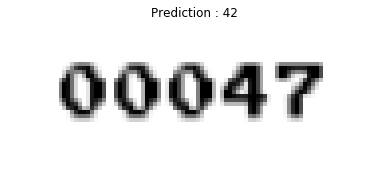

42

In [244]:
get_score()

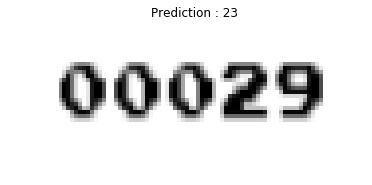

23

In [238]:
get_score()

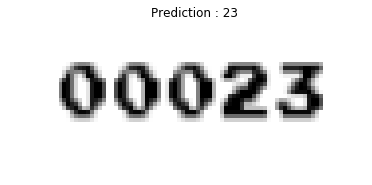

23

In [239]:
get_score()

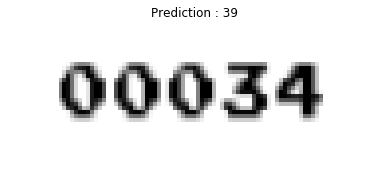

39

In [240]:
get_score()

## Using time as a metric

In [262]:
roi_array = np.zeros_like(np.array(grab_roi()))
pyautogui.click(x=1000,y = 500)
time.sleep(0.1)
pyautogui.press("up")
t = time.time()
while True:
    roi = grab_roi()
    if (np.array(roi) == roi_array).all():
        break
    roi_array = np.array(roi)
score = (time.time() - t)*10
print(score)    

45.05999803543091


***

# Creating the environment for RL

In [7]:
from dino import *

In [9]:
game = DinoGame()

In [9]:
game.refresh_page()

In [10]:
game.run_episode(policy = "rules")

232.44999885559082

***

# Developing a RL agent that learns via evolution strategies

![](https://www.researchgate.net/profile/Hongfang_Liu/publication/260377604/figure/fig2/AS:213452158181378@1427902368463/Genetic-Algorithm-Tree-Basic-steps-of-GA-selection-crossover-and-mutation.png)
- [Evolution Strategies as a scalable alternative for RL](https://arxiv.org/abs/1703.0386)
- [Example of ES with PyTorch](https://github.com/atgambardella/pytorch-es/blob/master/train.py)
- [Reinforce with PyTorch](https://github.com/pytorch/examples/blob/master/reinforcement_learning/reinforce.py)

## Preparing the crossover

In [116]:
dino1,dino2 = Dino(),Dino()

In [119]:
dino1.net.hidden.weight[0][0]

Variable containing:
1.00000e-02 *
  2.1606
[torch.FloatTensor of size 1]

In [120]:
dino2.net.hidden.weight[0][0]

Variable containing:
1.00000e-02 *
  1.1849
[torch.FloatTensor of size 1]

In [121]:
dino3 = dino1 + dino2

In [122]:
dino3.net.hidden.weight[0][0]

Variable containing:
1.00000e-02 *
  1.6727
[torch.FloatTensor of size 1]

## Preparing the mutation

In [17]:
dino = Dino()

In [18]:
dino.net.hidden.weight.data


-1.7239e-02 -2.3747e-03 -3.5258e-02  ...   4.7516e-04 -3.6161e-02  5.3403e-03
 3.0724e-02  2.3031e-02 -1.5182e-03  ...   3.5134e-02 -1.5162e-02  1.7255e-02
-2.2430e-02  1.8971e-02 -1.5770e-02  ...  -1.3198e-02 -2.8008e-02  2.8595e-02
                ...                   ⋱                   ...                
 1.3110e-02 -2.7484e-02 -3.2595e-02  ...   2.7802e-03  3.1248e-02  1.3684e-02
-3.1093e-02  8.4438e-03 -6.8824e-03  ...  -2.2317e-04 -2.2852e-02 -1.5473e-04
-2.1027e-02  3.1566e-03 -7.0412e-03  ...  -5.1858e-03  1.9055e-02  2.9326e-03
[torch.FloatTensor of size 100x700]

In [19]:
dino.mutate()

In [20]:
dino.net.hidden.weight.data


-1.4583e-01 -1.2402e-01 -1.0016e-01  ...   7.0636e-03 -1.0660e-01  2.4020e-03
 2.0102e-01  3.1091e-02 -8.1855e-02  ...   4.3296e-02 -1.5790e-01 -5.3639e-02
-1.3348e-02  7.5591e-03 -8.7820e-04  ...   5.7667e-02 -1.1699e-01 -1.7642e-01
                ...                   ⋱                   ...                
-5.0212e-03 -7.7862e-02 -3.8191e-02  ...  -2.0878e-01 -8.6070e-02 -5.0244e-02
-1.4975e-01  1.4860e-01  1.2195e-02  ...  -8.7780e-02 -4.1928e-02 -1.7079e-02
 5.5063e-02 -4.2361e-02 -5.6034e-02  ...  -1.4029e-01 -5.7278e-02  4.7856e-02
[torch.FloatTensor of size 100x700]

## Preparing a Logistic Regression

In [105]:
from dino import *
dino = Dino()

##### Logistic regression

In [84]:
lr = LogReg(700)
lr2 = LogReg(700)

In [94]:
lr.forward(Variable(torch.ones(700)))

Variable containing:
 0.6978
[torch.FloatTensor of size 1]

In [95]:
lr2.forward(Variable(torch.ones(700)))

Variable containing:
 0.3004
[torch.FloatTensor of size 1]

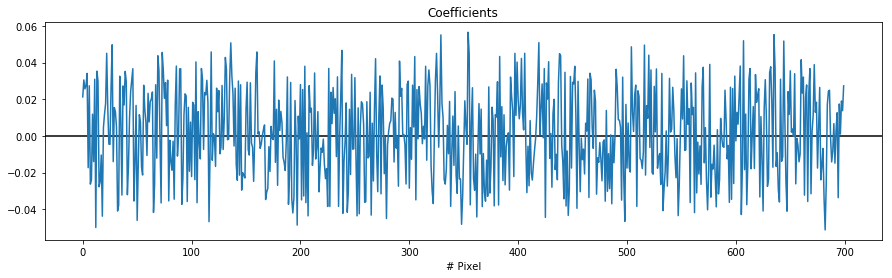

In [96]:
lr.plot_coefs()

In [97]:
lr3 = lr + lr2

In [99]:
lr3.forward(Variable(torch.ones(700)))

Variable containing:
 0.4989
[torch.FloatTensor of size 1]

In [100]:
lr.out.weight.data.numpy()[0][:5]

array([ 0.02125547,  0.03048904,  0.02562048,  0.02736993,  0.03406339], dtype=float32)

In [101]:
lr.mutate()

In [102]:
lr.out.weight.data.numpy()[0][:5]

array([ 0.01677739,  0.03200237,  0.02500765,  0.04204419,  0.03392242], dtype=float32)

In [104]:
lr.forward(Variable(torch.ones(700))).data.numpy()

array([ 0.6821903], dtype=float32)

## Running the game

In [9]:
game = DinoGame()

In [14]:
game.run_episode(policy = "rules",render = "contours")

308.8100028038025

In [ ]:
game.run_game(n = 40,method = "flat700lr",render = "contours")

100%|██████████████████████████████████████████| 40/40 [04:41<00:00,  7.03s/it]


Generation 0 : mean 58 - std 16 - max 123 - min 46


100%|██████████████████████████████████████████| 40/40 [04:38<00:00,  6.97s/it]


Generation 1 : mean 58 - std 17 - max 121 - min 28


100%|██████████████████████████████████████████| 40/40 [04:40<00:00,  7.00s/it]


Generation 2 : mean 58 - std 19 - max 148 - min 46


100%|██████████████████████████████████████████| 40/40 [04:27<00:00,  6.69s/it]


Generation 3 : mean 55 - std 12 - max 93 - min 35


100%|██████████████████████████████████████████| 40/40 [04:15<00:00,  6.40s/it]


Generation 4 : mean 52 - std 6 - max 77 - min 46


100%|██████████████████████████████████████████| 40/40 [04:35<00:00,  6.88s/it]


Generation 5 : mean 57 - std 16 - max 131 - min 47


100%|██████████████████████████████████████████| 40/40 [04:36<00:00,  6.90s/it]


Generation 6 : mean 57 - std 17 - max 136 - min 46


100%|██████████████████████████████████████████| 40/40 [04:29<00:00,  6.73s/it]


Generation 7 : mean 55 - std 14 - max 101 - min 20


100%|██████████████████████████████████████████| 40/40 [04:15<00:00,  6.39s/it]


Generation 8 : mean 52 - std 14 - max 103 - min 24


100%|██████████████████████████████████████████| 40/40 [04:37<00:00,  6.93s/it]


Generation 9 : mean 57 - std 13 - max 97 - min 47


100%|██████████████████████████████████████████| 40/40 [04:30<00:00,  6.77s/it]


Generation 10 : mean 56 - std 13 - max 106 - min 46


100%|██████████████████████████████████████████| 40/40 [04:25<00:00,  6.63s/it]


Generation 11 : mean 54 - std 10 - max 90 - min 46


100%|██████████████████████████████████████████| 40/40 [04:48<00:00,  7.20s/it]


Generation 12 : mean 60 - std 22 - max 131 - min 20


100%|██████████████████████████████████████████| 40/40 [04:24<00:00,  6.61s/it]


Generation 13 : mean 54 - std 12 - max 106 - min 47


100%|██████████████████████████████████████████| 40/40 [04:25<00:00,  6.63s/it]


Generation 14 : mean 54 - std 14 - max 101 - min 20


100%|██████████████████████████████████████████| 40/40 [04:36<00:00,  6.92s/it]


Generation 15 : mean 57 - std 12 - max 96 - min 46


 95%|███████████████████████████████████████▉  | 38/40 [04:19<00:13,  6.82s/it]

***

# Improve the environment with selenium capabilities

## Test with selenium screenshot

In [37]:
from io import BytesIO
x = Image.open(BytesIO(game.driver.get_screenshot_as_png()))

In [38]:
x.size

(942, 883)

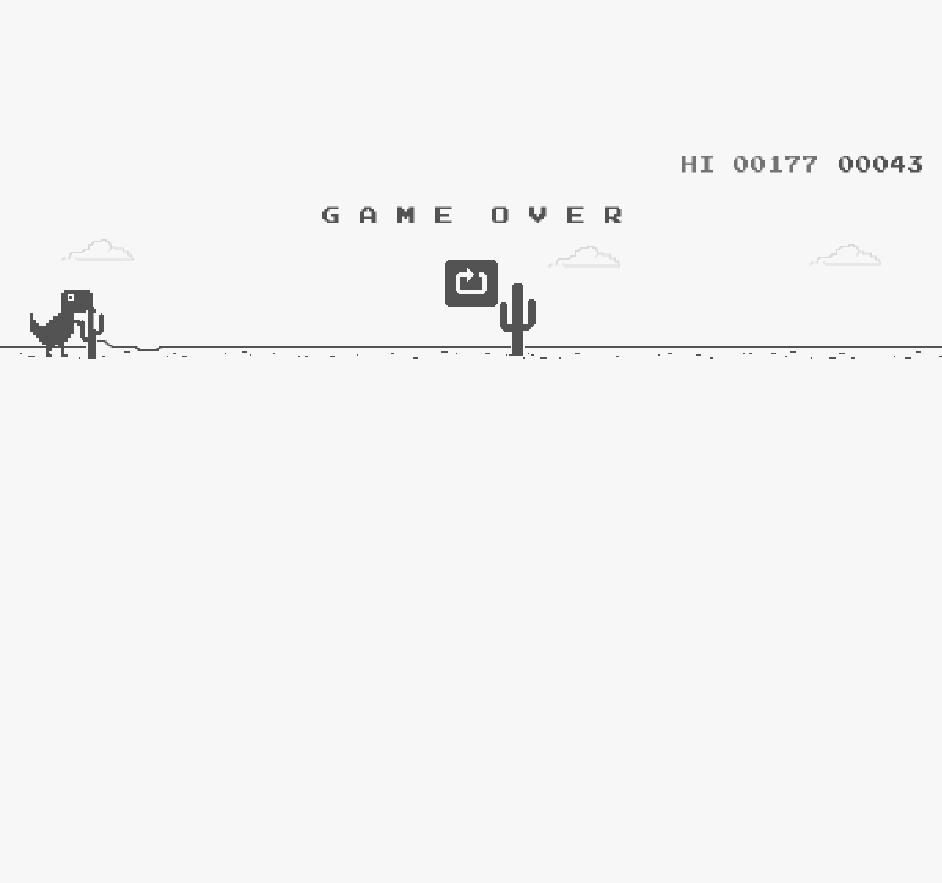

In [39]:
x

## New implementation of environment

In [74]:
from dino import *

In [75]:
game = DinoGame()

In [19]:
x = game.grab_roi()

In [20]:
x.size

(640, 305)

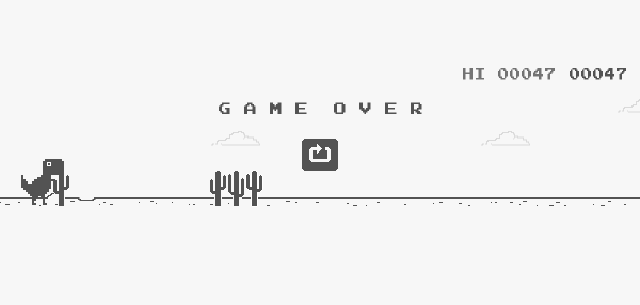

In [21]:
x

In [36]:
imgs,xs = game.grab_game()

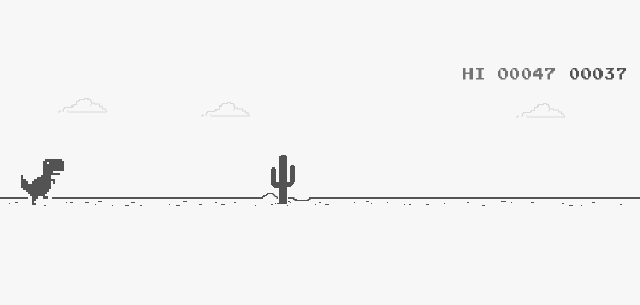

In [37]:
Image.fromarray(imgs["raw"])

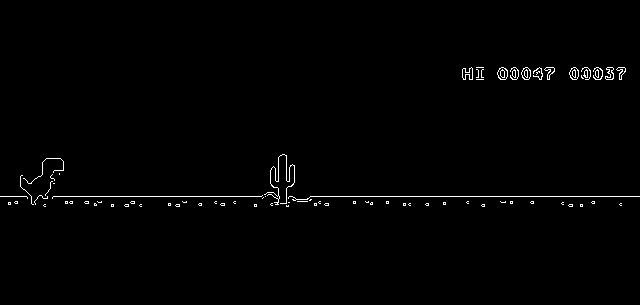

In [38]:
Image.fromarray(imgs["edges"])

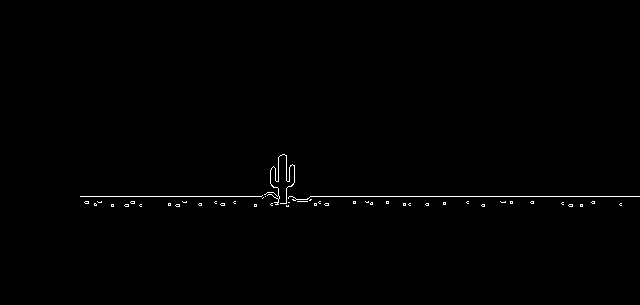

In [39]:
Image.fromarray(imgs["mask"])

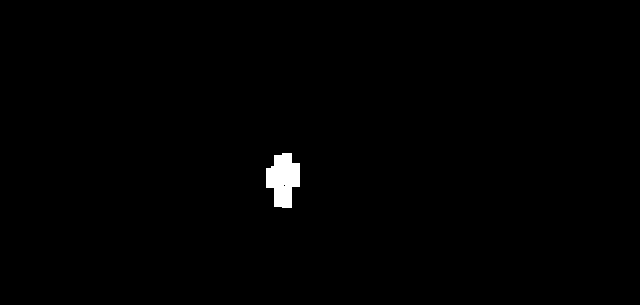

In [40]:
Image.fromarray(imgs["morph"])

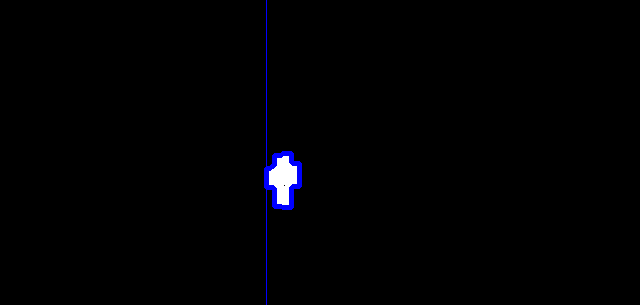

In [41]:
Image.fromarray(imgs["contours"])

In [42]:
xs

[266]

In [43]:
game.run_episode(policy="random")

54.26999807357788

In [ ]:
game.run_episode(policy = "rules")

In [54]:
import cProfile

In [70]:
from mss import mss

In [72]:
with mss() as sct:
    sct.shot()

In [76]:
cProfile.run("ImageGrab.grab(bbox=(1020,350,1850,600))")

         45 function calls in 0.067 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.067    0.067 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 Image.py:1059(crop)
        1    0.000    0.000    0.000    0.000 Image.py:1078(_crop)
        2    0.000    0.000    0.000    0.000 Image.py:2248(_check_size)
        1    0.000    0.000    0.005    0.005 Image.py:2266(new)
        1    0.000    0.000    0.008    0.008 Image.py:2297(frombytes)
        1    0.000    0.000    0.000    0.000 Image.py:2492(_decompression_bomb_check)
        1    0.000    0.000    0.000    0.000 Image.py:418(_getdecoder)
        3    0.000    0.000    0.000    0.000 Image.py:519(__init__)
        2    0.000    0.000    0.000    0.000 Image.py:539(_new)
        3    0.000    0.000    0.000    0.000 Image.py:586(__del__)
        1    0.000    0.000    0.003    0.003 Image.py:764(frombytes)
        1    

In [79]:
game.driver.get_window_position()

{'x': -8, 'y': -8}

In [77]:
cProfile.run("game.driver.get_screenshot_as_png()")

         442 function calls (441 primitive calls) in 0.476 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.476    0.476 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 <string>:12(__new__)
        2    0.000    0.000    0.000    0.000 __init__.py:1284(debug)
        2    0.000    0.000    0.000    0.000 __init__.py:1528(getEffectiveLevel)
        2    0.000    0.000    0.000    0.000 __init__.py:1542(isEnabledFor)
        1    0.000    0.000    0.000    0.000 __init__.py:183(dumps)
        1    0.000    0.000    0.000    0.000 __init__.py:302(loads)
        7    0.000    0.000    0.000    0.000 _policybase.py:281(_sanitize_header)
        2    0.000    0.000    0.000    0.000 _policybase.py:293(header_source_parse)
        7    0.000    0.000    0.000    0.000 _policybase.py:311(header_fetch_parse)
        1    0.000    0.000    0.000    0.000 base64.py:34(_bytes_from_deco

       18    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'close' of '_io.BufferedReader' objects}
        4    0.000    0.000    0.000    0.000 {method 'count' of 'str' objects}
        3    0.000    0.000    0.000    0.000 {method 'decode' of 'bytes' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
       22    0.000    0.000    0.000    0.000 {method 'encode' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {method 'end' of '_sre.SRE_Match' objects}
        1    0.000    0.000    0.000    0.000 {method 'endswith' of 'str' objects}
        2    0.000    0.000    0.000    0.000 {method 'extend' of 'collections.deque' objects}
        1    0.000    0.000    0.000    0.000 {method 'extend' of 'list' objects}
        7    0.000    0.000    0.000    0.000 {method 'find' of 'str' objects}
        6    0.000    0.000    0.000    0.000 {method 'f

In [63]:
cProfile.run("game.grab_roi()")

         602 function calls (601 primitive calls) in 0.375 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.375    0.375 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 <string>:12(__new__)
        1    0.000    0.000    0.000    0.000 BmpImagePlugin.py:49(_accept)
        1    0.000    0.000    0.000    0.000 GifImagePlugin.py:38(_accept)
        1    0.000    0.000    0.019    0.019 Image.py:1701(resize)
        1    0.000    0.000    0.000    0.000 Image.py:2492(_decompression_bomb_check)
        1    0.000    0.000    0.000    0.000 Image.py:2512(open)
        1    0.000    0.000    0.000    0.000 Image.py:2556(_open_core)
        1    0.000    0.000    0.000    0.000 Image.py:358(preinit)
        1    0.000    0.000    0.000    0.000 Image.py:418(_getdecoder)
        2    0.000    0.000    0.000    0.000 Image.py:519(__init__)
        1    0.000    0.000    0.000    0.

        2    0.000    0.000    0.000    0.000 parse.py:98(_noop)
        1    0.000    0.000    0.000    0.000 parser.py:18(__init__)
        1    0.000    0.000    0.000    0.000 parser.py:42(parse)
        1    0.000    0.000    0.000    0.000 parser.py:60(parsestr)
        1    0.000    0.000    0.000    0.000 remote_connection.py:165(get_remote_connection_headers)
        1    0.000    0.000    0.355    0.355 remote_connection.py:443(execute)
        1    0.000    0.000    0.355    0.355 remote_connection.py:462(_request)
        1    0.000    0.000    0.000    0.000 remote_connection.py:540(<listcomp>)
        1    0.000    0.000    0.000    0.000 socket.py:139(__init__)
        1    0.000    0.000    0.000    0.000 socket.py:218(makefile)
        1    0.000    0.000    0.000    0.000 socket.py:403(_decref_socketios)
        1    0.000    0.000    0.000    0.000 socket.py:409(_real_close)
        2    0.000    0.000    0.000    0.000 socket.py:413(close)
        1    0.000    0.00

        1    0.000    0.000    0.000    0.000 {method 'sub' of '_sre.SRE_Pattern' objects}
        3    0.000    0.000    0.000    0.000 {method 'tell' of '_io.BytesIO' objects}
        2    0.000    0.000    0.000    0.000 {method 'truncate' of '_io.StringIO' objects}
        1    0.000    0.000    0.000    0.000 {method 'update' of 'dict' objects}
        1    0.000    0.000    0.000    0.000 {method 'upper' of 'str' objects}
        1    0.000    0.000    0.000    0.000 {method 'write' of '_io.StringIO' objects}




In [57]:
import time
def hello(x):
    print(x)
    x = x+7
    time.sleep(1)
    return x